# **Tutorial 2: Filtering and Common Transformations**

In this notebook, we will learn how to implement basic 'cleaning' and spatio-temporal transformations of the data.

### Download the data
Download the file [IC2S2-2025.zip](https://drive.google.com/file/d/1wk3nrNsmAiBoTtWznHjjjPkmWAZfxk0P/view?usp=drive_link) and extract it to this folder to obtain the sample trajectory data used in this tutorial.

## Example cleaning:

1.	Select users that meet specified geographical and temporal conditions.  
2.	Extract the complete trajectories from those users
3.  Filter out users with insufficient data for our analysis

## Load Data

For this example, we will use a third dataset different than the one used in part 1, which has more users and, occasionally, denser signals. 

In [1]:
import nomad.io.base as loader

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

traj = loader.from_file(filepath_root, format='parquet', traj_cols=tc)
traj.head()

,gc_identifier,dev_x,dev_y,unix_ts,ha,tz_offset,date
0,admiring_brattain,-4.265481e+06,4.393146e+06,1704106881,10.702426,-14400,2024-01-01
1,admiring_brattain,-4.265533e+06,4.393159e+06,1704107003,19.015804,-14400,2024-01-01
2,admiring_brattain,-4.265477e+06,4.393185e+06,1704107072,24.851835,-14400,2024-01-01
3,admiring_brattain,-4.265490e+06,4.393156e+06,1704107268,10.181171,-14400,2024-01-01
4,admiring_brattain,-4.265491e+06,4.393147e+06,1704107349,11.100491,-14400,2024-01-01


## Ping Frequency

In [2]:
# We can investigate the frequency of these GPS signals, which can be very sparse
total_pings = traj.groupby(tc['user_id']).size()
total_hours = (traj[tc['timestamp']].max() - traj[tc['timestamp']].min())//3600

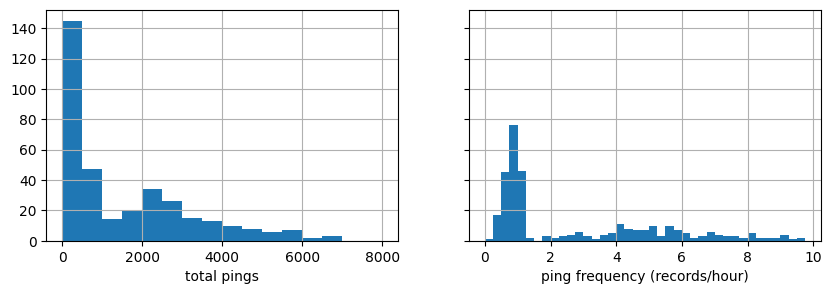

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.set_option("mode.copy_on_write", True)
pd.plotting.register_matplotlib_converters()

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)])
ax1.set_xlabel('total pings')

# x-axis restricted to bins
(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(40)])
ax2.set_xlabel('ping frequency (records/hour)')

plt.show()

We note **heterogeneity in the ping frequencies** and the volume of data. But *more records* =/= *more complete signals*. 

In [4]:
from nomad import filters

# Remove horizontal accuracy over 50m
traj_ds = traj.loc[traj[tc['ha']] < 50]
print(f"{((traj[tc['ha']]>50).mean()*100).round(3)}% pings have 'ha' > 50m")
# Downsampling pings to once per minute
num_mins=5 # Try 5
traj_ds = filters.downsample(traj_ds, periods=num_mins, verbose=True, traj_cols=tc)

1.715% pings have 'ha' > 50m
44.088% of rows removed by downsampling to 5min windows per user.


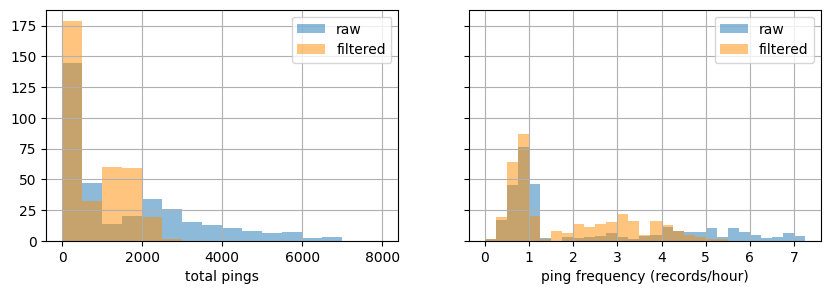

In [5]:
total_pings_filtered = traj_ds.groupby(tc['user_id']).size()

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)], alpha=0.5, label='raw')
total_pings_filtered.hist(ax=ax1, bins= [500*b for b in range(17)], color='darkorange', alpha=0.5, label='filtered')
ax1.legend()
ax1.set_xlabel('total pings')

(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], alpha=0.5, label='raw')
(total_pings_filtered/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], color='darkorange', alpha=0.5, label='filtered')
ax2.set_xlabel('ping frequency (records/hour)')
ax2.legend()

plt.show()

## Spatial filters and Projections

Suppose we are interested in an analysis of users who visited a park during multiple days, e.g. **3 days**, of January 2024, and we want to know the other locations they visited.

- The polygon could be in **spherical coordinates** (also called **geographic coordinates**) and the data in **projected coordinates**. For example, in `(longitude, latitude)` coordinates with `crs='EPSG:4326'`, while the data has ``` (x, y)``` coordinates from the Web Mercator crs (`'EPSG:3857'`).

- The polygon could be represented as a Well-Known-Text string (`wkt`), `shapely` polygon (or multipolygon), or a `Geopandas.GeoSeries`

### Load the geometry data

In [6]:
import geopandas as gpd
import pyproj # for coordinate reprojection
from shapely.geometry import Polygon, box

city = gpd.read_file("garden_city.geojson").set_index('building_id')
outer_box = box(*city.total_bounds).buffer(0.00015, join_style='mitre') # "background" box
# poly = city.geometry.loc['p-x13-y11'] #uncomment for comparing

poly_wkt = 'POLYGON ((-38.31767437672955 36.66929877196072, -38.31767437672955 36.66973109167419,'\
                     '-38.31821336590002 36.66973109167419, -38.31821336590002 36.66929877196072,'\
                     '-38.31767437672955 36.66929877196072))'
poly = gpd.GeoSeries.from_wkt([poly_wkt])[0]

### Check if a user has pings inside the park 

We start by analyzing the data from a single user. Checking which pings fall inside a given polygon is trivial with `geopandas.GeoDataFrame.within`. However, the polygon and the passed pings must have the same CRS. Reprojection is also quite simple if we cast our dataset as a `GeoDataFrame`. 

In [7]:
user_df = traj.loc[(traj[tc['user_id']] == 'heuristic_lamport')] # try 'gifted_galileo'
# Cast to GeoDataFrame and reproject (easy)
user_df = gpd.GeoDataFrame(user_df,
                           geometry=gpd.points_from_xy(user_df['dev_x'], user_df['dev_y']),
                           crs='EPSG:3857').to_crs('EPSG:4326')

user_df['in_park'] = user_df.within(poly)
user_df = user_df[user_df.within(outer_box)] # For plotting purposes

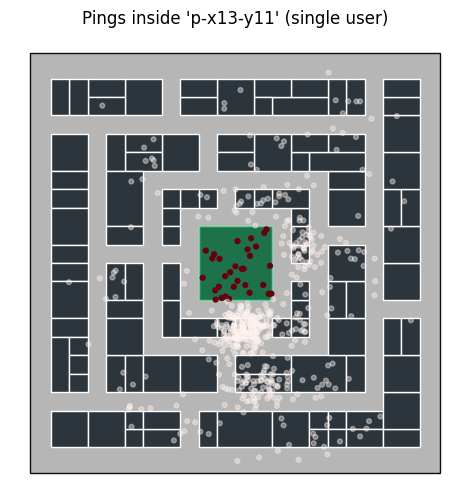

In [8]:
import shapely.plotting as shp_plt
# for pretty plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_axis_off()

shp_plt.plot_polygon(outer_box, ax=ax, add_points=False, color='#0e0e0e')
city.plot(ax=ax, edgecolor='white', color='#2c353c')
shp_plt.plot_polygon(poly, ax=ax, add_points=False, color='#0fad5a', alpha=0.5)
user_df.plot(ax=ax, column='in_park', marker='o', markersize=12, alpha=(0.4+user_df.in_park*0.6), cmap='Reds') # Try cmap='inferno'
ax.set_title("Pings inside 'p-x13-y11' (single user)")

plt.show()

### Qualification constraints: minimum pings and minimum active days

Trajectories are **noisy**, so some of the pings falling within the park might actually come from commuting or visiting buildings in the vicinity. To get *bona-fide* park visitors in the final analysis we need to address this possibiility. Because of sparsity and burstiness, a **simple ping count could be misleading** and not indicative of actual **dwelling** or **stopping** at the location. Let's remove some of the spurious visits by downsampling the pings in the park to **every 20 minutes**. We formulate the new definition for our sample:

**Park Visitors** = users with at least **2 pings** in the park, separated by at least **20 minutes**, in each of, **at least 5 days**. 


<small>
*Properly detecting stops requires some form of clustering in space and time and is explained in the [stop-detection notebook](./[3]stop-detection.ipynb).
</small>

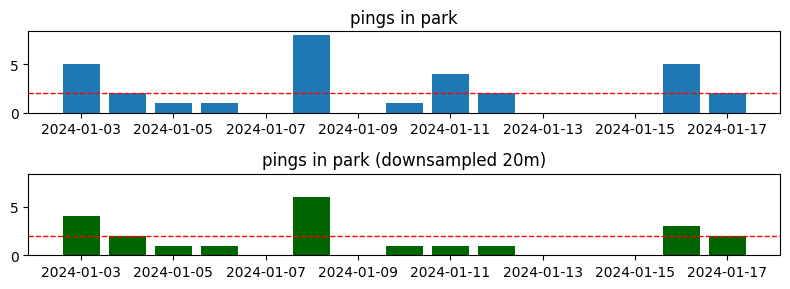

In [9]:
park_pings = user_df.query('in_park == True').groupby('date').size()
park_pings_filtered = filters.downsample(user_df.query('in_park == True'), periods=20, freq='min', **tc).groupby('date').size()

fig, (ax1, ax2) = plt.subplots(figsize=(8,3), nrows=2, sharey=True)

ax1.set_title("pings in park")
ax1.bar(x=park_pings.index, height=park_pings)

ax2.set_title("pings in park (downsampled 20m)")
ax2.bar(x=park_pings_filtered.index, height=park_pings_filtered, color='darkgreen')

[ax.axhline(y=2, linewidth=1, color='r', linestyle='--') for ax in (ax1, ax2)]

plt.tight_layout()
plt.show()

Does our sample user make the cut?

### Qualification constraints: signal completeness (q)

We filter incomplete users because *incompleteness bias* can be severe. We quantify the *completeness* of a user with, $q$, the percentage of 'time buckets' with any pings given by some resolution (e.g. hours or days). 

Note that:
- $q$ is the average of the hourly "coverage mask" of a user.
- On the other hand, from the *coverage matrix* of all users, we could get the users active each hour (HAU), day (DAU) or monthly (MAU)

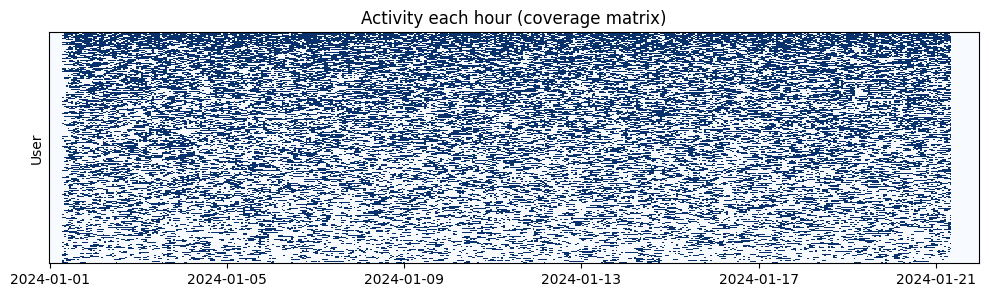

In [10]:
Q = filters.coverage_matrix(traj, periods=1, freq='h', traj_cols=tc, start='2024-01-01', end='2024-01-22', str_from_time=True)
completeness_hourly = Q.mean(1)

fig, ax = plt.subplots(figsize=(12, 3))

Q = Q.iloc[completeness_hourly.argsort(-1)]
Q.columns = pd.to_datetime(Q.columns)

ax.pcolormesh(Q.columns, range(len(Q)), Q.values,               # plot matrix
               cmap='Blues', shading='auto')

ax.set_yticks([])
ax.set_ylabel('User')
ax.set_title('Activity each hour (coverage matrix)')

plt.show()

Alternatively, we can see this matrix aggregated to a higher resolution with a convenient wrapper `filters.completeness`

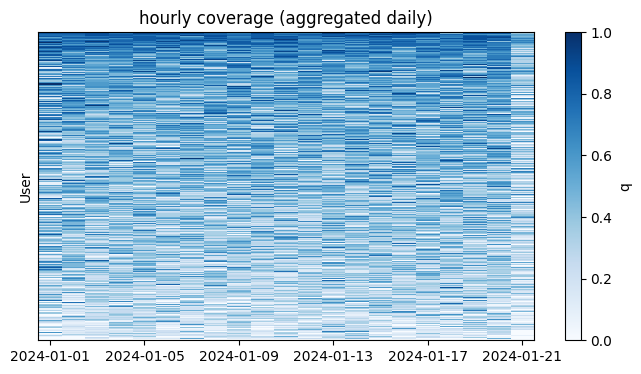

In [11]:
Q = filters.completeness(traj, periods=1, freq='h', agg_freq='d', traj_cols=tc)

Q = Q.iloc[completeness_hourly.argsort(-1)]
Q.columns = pd.to_datetime(Q.columns)

fig, ax = plt.subplots(figsize=(8, 4))
pcm = ax.pcolormesh(Q.columns, range(len(Q)), Q.values,               # plot matrix
               cmap='Blues', shading='auto')
ax.set_yticks([])
ax.set_ylabel('User')
ax.set_title('hourly coverage (aggregated daily)')

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', label='q')

plt.show()

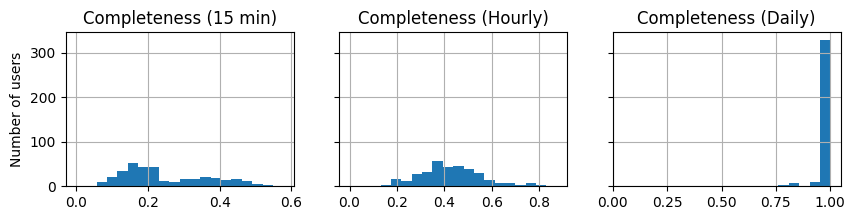

In [12]:
# Let's use one of nomad's wrappers to compute this completeness at different resolutions
q_15m = filters.completeness(traj, periods=15, freq='min', traj_cols=tc)
q_hourly = filters.completeness(traj, periods=1, freq='h', traj_cols=tc)
q_daily = filters.completeness(traj, periods=1, freq='d', traj_cols=tc)

# we visualize them as side by side histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 2))

ax1.hist(q_15m, bins=20)
ax1.set_title('Completeness (15 min)')
ax1.set_ylabel('Number of users')


ax2.hist(q_hourly, bins=20)
ax2.set_title('Completeness (Hourly)')

ax3.hist(q_daily, bins=20)
ax3.set_title('Completeness (Daily)')

[ax.grid() for ax in (ax1, ax2, ax3)]
plt.show()

It seems like users have excellent daily completeness, but several hour gaps. Let's keep only users that have `q_hourly>0.4`

## Putting it all together

Let's implement, from scratch, the filtering and cleaning that will define our sample of users in our analysis of parks in a few steps that chain `nomad.filters` methods with groupbys

In [13]:
# ingest
tc = {"user_id": "gc_identifier", "timestamp": "unix_ts", "x": "dev_x", "y": "dev_y", "ha":"ha", "date":"date"}
traj = loader.from_file('gc_data_long/', format='parquet', traj_cols=tc)

# let's rename the columns to get default names
tc_reverse = {v:k for k,v in tc.items()}
traj.rename(columns=tc_reverse, inplace=True)

In [14]:
poly_wkt = 'POLYGON ((-38.31767437672955 36.66929877196072, -38.31767437672955 36.66973109167419,'\
                     '-38.31821336590002 36.66973109167419, -38.31821336590002 36.66929877196072,'\
                     '-38.31767437672955 36.66929877196072))'

# Visitors to the park
traj_clean = filters.downsample(traj.query('ha < 50'), periods=1, freq='min')

# at least 2 pings 20 minutes apart each day of at least 5 days
pings_in_poly = filters.within(traj_clean, within=poly_wkt, x='x', y='y', data_crs='EPSG:3857', poly_crs='EPSG:4326')

days_w_2_pings = (
    filters.downsample(pings_in_poly, periods=20, freq='min')
    .groupby(['user_id', 'date']).size().reset_index(name='pings')  # <<< count pings per userxdate
    .query('pings >= 2') # <<< filter
)

park_visitors = days_w_2_pings.groupby('user_id').size().loc[lambda s: s >= 5].index # <<< park visitors

# completeness > 0.4
user_sample = filters.completeness(traj_clean.query('user_id in @park_visitors'), periods=1, freq='h').loc[lambda s: s>0.4].index

## Which locations do these users visit?

Let's use some stop detection to find the locations with the most user-minutes. We will dive deeper into how stop detection works in the next module, for now we just call the `nomad.stop_detection.grid_based` method.

In [16]:
%%time 
import nomad.visit_attribution.visit_attribution as visits
import nomad.stop_detection.grid_based as stop_detection

data_sample = traj_clean.query('user_id in @user_sample')
data_sample['location_id'] = visits.poi_map( data_sample, poi_table=city, data_crs='EPSG:3857', x='x', y='y')

stops = stop_detection.grid_based_per_user(data_sample, time_thresh=120, dur_min=5, x='x', y='y', location_id='location_id', complete_output=True)

C:\Users\pacob\Desktop\Brain\Code Development\virtual-environments\nomad-venv\Lib\site-packages\nomad\visit_attribution\visit_attribution.py:212: UserWarning: CRS for `poi_table` does not match crs for `data`. Reprojecting...
  warnings.warn("CRS for `poi_table` does not match crs for `data`. Reprojecting...")
C:\Users\pacob\Desktop\Brain\Code Development\virtual-environments\nomad-venv\Lib\site-packages\nomad\visit_attribution\visit_attribution.py:223: UserWarning: location_id column not provided, defaulting to poi_table.index for spatial join.
  warnings.warn(f"location_id column not provided, defaulting to poi_table.index for spatial join.")


CPU times: total: 20.1 s
Wall time: 20.5 s


In [17]:
city['total_mins'] = stops.groupby('location_id').duration.sum()
top_pois = city.total_mins.nlargest(12).iloc[1:].index  #  exclude the park

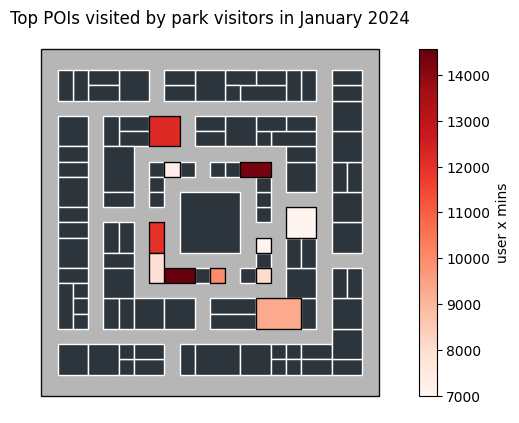

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_axis_off()

shp_plt.plot_polygon(outer_box, ax=ax, add_points=False, color='#0e0e0e')
city.plot(ax=ax, edgecolor='white', color='#2c353c')
city.loc[top_pois].plot(ax=ax, edgecolor='black', column='total_mins', cmap='Reds',  legend=True, legend_kwds={'shrink': 0.75, 'label':'user x mins'})

ax.set_title("Top POIs visited by park visitors in January 2024")
plt.show()